# Variational Quantum Eigensolver

In [13]:
# !pip install openfermionpyscf matplotlib scipy

In [14]:
import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

np.random.seed(42)

cudaq.set_target("nvidia")

The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance. 

The interatomic electrostatic forces due to the electrons and protons and the sheilding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration. 

Let us first begin by defining the molecule and other metadata about the problem.


In [15]:
# Number of hydrogen atoms.
hydrogen_count = 2  

# Distance between the atoms in Angstroms.
bond_distance = 0.7474  

# Define a linear chain of Hydrogen atoms 
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

hamiltonian, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry,
    basis='sto-3g',
    multiplicity=1,
    charge=0,
    n_active_electrons=None,
    n_active_orbitals=None)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

We now generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from the template provided by CUDAQ.  

In [16]:
kernel, angles = cudaq.make_kernel(list)
qubits = kernel.qalloc(qubit_count)

# Prepare the Hartree Fock State.
kernel.x(qubits[0])
kernel.x(qubits[1])

# Adds parameterized gates based on the UCCSD ansatz.
cudaq.kernels.uccsd(kernel, qubits, angles, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

We use the builtin optimizers within CUDAQ for the minimization procedure.

In [17]:
optimizer = cudaq.optimizers.COBYLA()

optimized_energy, parameters = cudaq.vqe(kernel,
                               hamiltonian,
                               optimizer,
                               parameter_count=parameter_count)

print(optimized_energy)

-1.1371756094989427


## Scipy Optimizers

We can also integrate popular libraries like scipy with CUDA Quantum. 

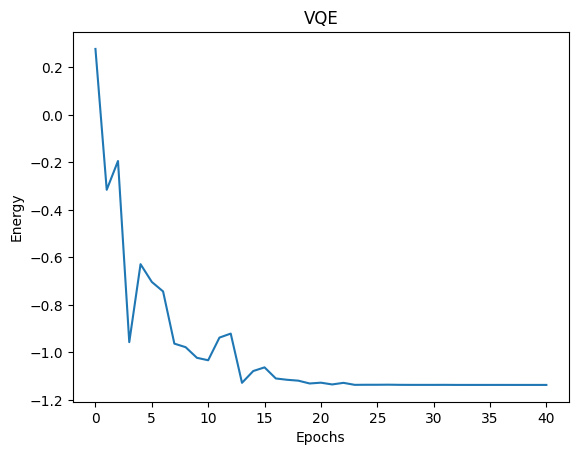

In [18]:
# Define a function to minimize 
def to_minimize(theta):

    exp_val = cudaq.observe(kernel, hamiltonian, theta).expectation()

    return exp_val


exp_vals = []
def callback(xk):
    exp_vals.append(to_minimize(xk))


# Initial variational parameters.
x0 = np.random.uniform(low=0, high=2 * np.pi, size=parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(to_minimize,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()